In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [52]:
import xgboost as xgb
from sklearn import model_selection
from sklearn import metrics

# EDA

In [73]:
# 10% order by user
SAMPLE_MAX_USER_ID = 20000
TRAIN_MAX_USER_ID = SAMPLE_MAX_USER_ID * 0.8

In [2]:
df_orders = pd.read_csv('../input/orders.csv')

In [3]:
df_orders_prior = df_orders[df_orders.eval_set=='prior']
df_orders_train = df_orders[df_orders.eval_set=='train']
# df_orders_prior = df_orders[df_orders.eval_set=='test']

In [11]:
df_orders_prior.set_index('order_id', inplace=True, drop=False)

In [128]:
df_orders_train.set_index('order_id', inplace=True, drop=False)

In [121]:
df_order_products_prior = pd.read_csv('../input/order_products__prior.csv')
df_order_products_prior.set_index('order_id', inplace=True, drop=False)

In [5]:
df_order_products_train = pd.read_csv('../input/order_products__train.csv')

In [121]:
df_order_products_train.set_index('order_id', inplace=True, drop=False)

In [119]:
df_products = pd.read_csv("../input/products.csv")
df_products.set_index('product_id', inplace=True, drop=False)

In [12]:
df_orders_prior_sample = df_orders_prior[df_orders_prior.user_id <= SAMPLE_MAX_USER_ID]
df_orders_prior_sample.shape

(310189, 7)

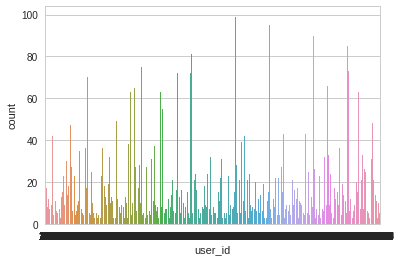

In [14]:
sns.countplot(x='user_id', data=df_orders_prior_sample)

In [129]:
df_orders_train_sample = df_orders_train[df_orders_train.user_id <= SAMPLE_MAX_USER_ID]
df_orders_train_sample.shape

(12796, 7)

In [17]:
df_order_join_product = df_orders_prior_sample.join(df_order_products_prior, rsuffix='_right')

In [94]:
df_order_join_product.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_id_right,product_id,add_to_cart_order,reordered
order_id,,,,,,,,,,,
8,8,3107,prior,5,4,6,17.0,8,23423,1,1
14,14,18194,prior,49,3,15,3.0,14,20392,1,1
14,14,18194,prior,49,3,15,3.0,14,27845,2,1
14,14,18194,prior,49,3,15,3.0,14,162,3,1
14,14,18194,prior,49,3,15,3.0,14,2452,4,1


In [25]:
df_order_join_product.to_csv('../input/order_join_product_my.csv', index=False)

In [131]:
df_order_join_product_final = df_orders_train_sample.join(df_order_products_train, rsuffix='_right')

In [133]:
df_order_join_product_final.to_csv('../input/order_join_product_final_my.csv', index=False)

In [2]:
df_order_join_product = pd.read_csv('../input/order_join_product_my.csv')

In [3]:
df_order_join_product_final = pd.read_csv('../input/order_join_product_final_my.csv')

# Product

In [134]:
df_product_statistic = DataFrame()
df_product_statistic['order_num'] = df_order_products_prior.groupby(
    'product_id', sort=False).size().astype(np.float32)

In [136]:
df_product_statistic['reorder_num'] = df_order_products_prior.reordered.groupby(
    df_order_products_prior.product_id).sum().astype(np.float32)

In [137]:
df_product_statistic['reorder_rate'] = (df_product_statistic.reorder_num / 
    df_product_statistic.order_num).astype(np.float32)

In [141]:
df_products = df_products.join(df_product_statistic)

In [142]:
df_products.head()

,product_id,product_name,aisle_id,department_id,order_num,reorder_num,reorder_rate
product_id,,,,,,,
1,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
2,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
3,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
4,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
5,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [143]:
df_products.to_csv('../input/df_products_my.csv', index=False)

In [4]:
MAX_PRODUCT_ID = 100000

def get_upid(user_id, product_id):
    return user_id * MAX_PRODUCT_ID + product_id

def get_upid_by_group(group):
    row0 = group.iloc[0]
    return row0.user_id * MAX_PRODUCT_ID + row0.product_id

def get_upid_by_tuple(tupl):
    return tupl[0] * MAX_PRODUCT_ID + tupl[1]

def get_uid_and_pid(upid):
    return upid / MAX_PRODUCT_ID, upid % MAX_PRODUCT_ID

In [5]:
group_user_product = df_order_join_product.groupby(['user_id', 'product_id'], sort=False)

In [6]:
upids = group_user_product.apply(get_upid_by_group)
df_train = DataFrame(index=upids)

In [28]:
df_train['label'] = 0

In [29]:
final_upids = df_order_join_product_final.groupby(['user_id', 'product_id'], sort=False).apply(get_upid_by_group)

In [30]:
df_train.loc[final_upids.loc[final_upids.isin(df_train.index)], 'label'] = 1

In [31]:
df_train.label.value_counts()

0    1197764
1      80227
Name: label, dtype: int64

In [32]:
(df_train.label == 1).sum() / float(df_train.shape[0])

0.062775872443546155

In [11]:
reorder_num = group_user_product['reordered'].sum()
df_train.loc[reorder_num.index.map(get_upid_by_tuple), 'reorder_num'] = reorder_num.values

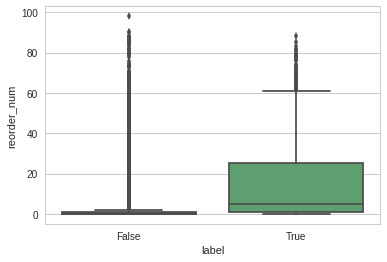

In [80]:
sns.boxplot(x='label', y='reorder_num', data=df_train)

In [21]:
df_train['reorder_num_compress'] = df_train.reorder_num
df_train.loc[df_train.reorder_num >= 5, 'reorder_num_compress'] = 5

In [34]:
total = df_train.reorder_num_compress.value_counts()
reorder = df_train[df_train.label==True].reorder_num_compress.value_counts()

In [35]:
reorder/total

0    0.030301
1    0.067068
2    0.098720
3    0.119490
4    0.135636
5    0.195872
Name: reorder_num_compress, dtype: float64

In [41]:
df_train['is_multi_reorder'] = False
df_train.loc[df_train.reorder_num >= 2, 'is_multi_reorder'] = True

In [42]:
df_train.is_multi_buy.sum()/float(df_train.shape[0])

0.23494453403818963

In [12]:
add_to_cart_order = group_user_product.add_to_cart_order.mean()

In [13]:
df_train.loc[add_to_cart_order.index.map(get_upid_by_tuple), 'add_to_cart_order'] = add_to_cart_order.values

In [14]:
df_train.add_to_cart_order = df_train.add_to_cart_order.astype(np.int32)

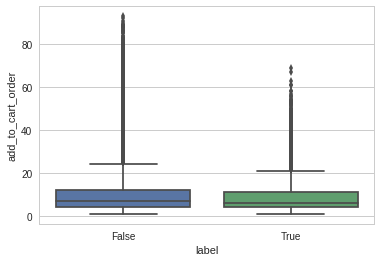

In [57]:
sns.boxplot(x='label', y='add_to_cart_order', data=df_train)

In [62]:
df_train.add_to_cart_order.describe()

count    1.277991e+06
mean     9.030955e+00
std      6.975552e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.200000e+01
max      9.300000e+01
Name: add_to_cart_order, dtype: float64

In [63]:
df_train[df_train.add_to_cart_order > 25] = 25

In [66]:
a =  df_train[df_train.add_to_cart_order <= 5 ]
(a.label == True).sum() / float(a.shape[0])

0.072559533095550008

In [73]:
a =  df_train[(df_train.add_to_cart_order > 5) & (df_train.add_to_cart_order < 25)]

In [75]:
(a.label == True).sum() / float(a.shape[0])

0.058222279895297151

In [89]:
df_train.label.corr(df_train.add_to_cart_order, 'spearman')

0.14224587540921482

In [15]:
product_order_num = df_order_join_product.groupby('product_id', sort=False).size()

In [16]:
def get_product_order_num(puid):
    return product_order_num[puid % MAX_PRODUCT_ID]
df_train['product_order_num'] =  df_train.index.map(get_product_order_num)

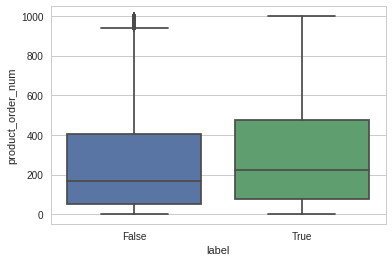

In [17]:
sns.boxplot(x='label', y='product_order_num', data=df_train[df_train.product_order_num < 1000])

In [18]:
df_train.columns

Index([u'label', u'reorder_num', u'add_to_cart_order', u'product_order_num'], dtype='object')

In [33]:
scale_pos_weight = float((df_train.label == 0).sum()) / (df_train.label==1).sum()

# Model

In [48]:
RAND_SEED = 0
K_FOLD = 5

In [85]:
def get_user_id(upid):
    return upid / MAX_PRODUCT_ID
df_train['user_id'] = df_train.index.map(get_user_id)

In [74]:
def get_train_sample(upid):
    return upid / MAX_PRODUCT_ID <= TRAIN_MAX_USER_ID

In [87]:
is_train = df_train.index.map(get_train_sample)
df_train_sample = df_train[is_train]
df_val_sample = df_train[~is_train]

In [76]:
print df_train_sample.shape, df_val_sample.shape

(1021774, 4) (256217, 4)


In [78]:
print (df_train_sample.label == 1).sum(), (df_val_sample.label == 1).sum()

64083 16144


In [90]:
feaure_to_use = ['reorder_num', 'add_to_cart_order', 'product_order_num']

In [91]:
X_train = df_train_sample[feaure_to_use]
y_true = df_train_sample.label

In [80]:
xgbc = xgb.XGBClassifier(max_depth=6, nthread=-1, n_estimators=50)

In [43]:
xgbc.fit(X_train, y_true)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [44]:
xgbc.score(X_train, y_true)

0.937258556593904

In [50]:
X_test = X_train[y_true==1].iloc[:10]

In [51]:
xgbc.predict_proba(X_test)

array([[ 0.77621198,  0.22378802],
       [ 0.81111169,  0.18888828],
       [ 0.75804251,  0.24195749],
       [ 0.78572047,  0.21427953],
       [ 0.72178507,  0.2782149 ],
       [ 0.75128871,  0.24871129],
       [ 0.88424283,  0.11575718],
       [ 0.78855056,  0.21144946],
       [ 0.67311645,  0.32688358],
       [ 0.63499534,  0.36500466]], dtype=float32)

In [81]:
xgbc = xgb.XGBClassifier(nthread=-1)
param_grid = dict(n_estimators=[50], max_depth=[6, 10])
xgbc_gs = model_selection.GridSearchCV(xgbc, param_grid, cv=K_FOLD, scoring='roc_auc')

In [82]:
xgbc_gs.fit(X_train, y_true)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50], 'max_depth': [6, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [84]:
xgbc_gs.best_estimator_.feature_importances_

array([ 0.13017356,  0.29572764,  0.57409883], dtype=float32)

In [72]:
X_train.columns

Index([u'reorder_num', u'add_to_cart_order', u'product_order_num'], dtype='object')

In [83]:
DataFrame(data=xgbc_gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.054796,0.086941,0.749863,0.730979,6,50,"{u'n_estimators': 50, u'max_depth': 6}",1,0.760043,0.735243,...,0.779386,0.717219,0.747516,0.728450,0.680109,0.754568,0.106293,0.005146,0.037138,0.013447
1,7.945019,0.142577,0.746059,0.747251,10,50,"{u'n_estimators': 50, u'max_depth': 10}",2,0.758511,0.750396,...,0.775291,0.734442,0.743571,0.745519,0.674873,0.769685,0.117825,0.010014,0.037700,0.012666


In [92]:
X_val = df_val_sample[feaure_to_use]

In [93]:
preds = xgbc_gs.best_estimator_.predict(X_val)

In [94]:
df_val_sample['preds'] = preds

/home/damonhao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [104]:
def get_f_score(df_group):
    return metrics.f1_score(df_group.label, df_group.preds) if df_group.preds.any() else 0

def get_mean_f_score(df_val):
    f_scores = df_val.groupby('user_id').apply(get_f_score)
    return f_scores[f_scores>0].mean()

In [105]:
get_mean_f_score(df_val_sample)

0.25361811391223155

In [110]:
metrics.recall_score(df_val_sample.label, df_val_sample.preds)

0.00024777006937561942

In [111]:
metrics.precision_score(df_val_sample.label, df_val_sample.preds)

0.30769230769230771

In [112]:
metrics.accuracy_score(df_val_sample.label, df_val_sample.preds)

0.93697139534066831

In [116]:
((df_val_sample.label==0) & (df_val_sample.preds==1)).sum()

9

In [117]:
((df_val_sample.label==1) & (df_val_sample.preds==1)).sum()

4

In [100]:
f_scores = df_val_sample.groupby('user_id').apply(get_f_score)

In [103]:
f_scores[f_scores > 0]

user_id
16313    0.285714
16561    0.117647
17086    0.500000
18741    0.111111
dtype: float64

In [109]:
df_val_sample[df_val_sample.user_id==19999]

,label,reorder_num,add_to_cart_order,product_order_num,user_id,preds
1999917459,1,22,5,86,19999,0
1999900010,0,17,4,262,19999,0
1999903957,0,14,6,3680,19999,0
1999927104,1,11,5,6992,19999,0
1999918020,1,10,7,72,19999,0
1999944987,1,10,7,2176,19999,0
1999912023,0,3,6,340,19999,0
1999943662,0,5,10,1192,19999,0
1999934358,0,6,10,3436,19999,0
1999946611,0,7,7,48,19999,0


In [106]:
user_buy = df_val_sample.groupby('user_id').label.sum()

In [107]:
user_buy[user_buy > 0]

user_id
16002     2
16007    11
16008     5
16009     2
16011     9
16013    15
16014    11
16015     1
16016     8
16017     3
16021     6
16023     8
16024     3
16026     5
16029     7
16030    11
16032    31
16035     4
16036     1
16037    17
16038     1
16040     4
16041     5
16046    15
16051     4
16052     1
16054     5
16056    10
16059     1
16060    11
         ..
19956     2
19957     3
19958    17
19960     2
19962    26
19963     4
19965     9
19966     8
19967     6
19970     8
19973     4
19974     3
19976     4
19977     2
19978     7
19979     3
19980     1
19981     2
19982     4
19984     9
19987     1
19988     4
19990    21
19991    27
19993     3
19994     4
19995     7
19998    14
19999    14
20000     1
Name: label, dtype: int64

In [110]:
a = DataFrame({'c':[1, 2, 2], 'd':[2, 2, 2]})

In [111]:
def fun(df):
    return 3

In [113]:
a

,c,d
0,1,2
1,2,2
2,2,2


In [116]:
a.apply(fun, axis=1)

0    3
1    3
2    3
dtype: int64

In [115]:
a.sum(axis=1)

0    3
1    4
2    4
dtype: int64